# Named Entity Recognition: RNN vs Pre-Trained Transformer

Setup

In [10]:
# Basic 
import json
import random
import sys
import copy
from collections import Counter
from tqdm import tqdm
from itertools import product

# Data
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

# GloVe
import gensim.downloader

# RNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

# Transformers
from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    EarlyStoppingCallback,
    Trainer
)

# Metrics
import evaluate

with open("config.json") as f:
    config = json.load(f)
config

{'rnn': {'num_experiments': 20,
  'max_num_epochs': 100,
  'patience': 5,
  'hyperparameters': {'learning_rate': [0.001, 0.0003, 0.0001, 3e-05, 1e-05],
   'hidden_dim': [300, 450, 600],
   'num_layers': [2, 3, 4, 5],
   'batch_size': [32, 64, 128, 256, 512],
   'dropout': [0.1, 0.2, 0.3]}},
 'transformer': {'max_num_epochs': 3,
  'evals_per_epoch': 5,
  'patience': 3,
  'hyperparameters': {'training_samples': [512, 1024, 2048, 4096, 8192],
   'learning_rate': [3e-05, 0.0001],
   'batch_size': [64, 128, 256]}}}

## 1 &ensp; RNN

### 1.1 &ensp; Data Exploration & Analysis

Download GloVe pre-trained embeddings

In [2]:
glove_embeddings = gensim.downloader.load("glove-wiki-gigaword-300")

len(glove_embeddings), len(glove_embeddings[0])

(400000, 300)

Load CoNLL2003 dataset

In [2]:
conll2003_dataset = load_dataset("conll2003")

{split: dataset.num_rows for split, dataset in conll2003_dataset.items()}

{'train': 14041, 'validation': 3250, 'test': 3453}

In [4]:
conll2003_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [3]:
tag_names = conll2003_dataset['train'].features['ner_tags'].feature.names
tag2id = {tag: i for i, tag in enumerate(tag_names)}
id2tag = {i: tag for i, tag in enumerate(tag_names)}

tag2id, id2tag

({'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6,
  'B-MISC': 7,
  'I-MISC': 8},
 {0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC',
  7: 'B-MISC',
  8: 'I-MISC'})

Visualize some dataset statistics

In [25]:
lengths = []
tokens = []
tags = []

for seq in conll2003_dataset['train']:
    lengths.append(len(seq['tokens']))
    tokens.extend(seq['tokens'])
    tags.extend(seq['ner_tags'])

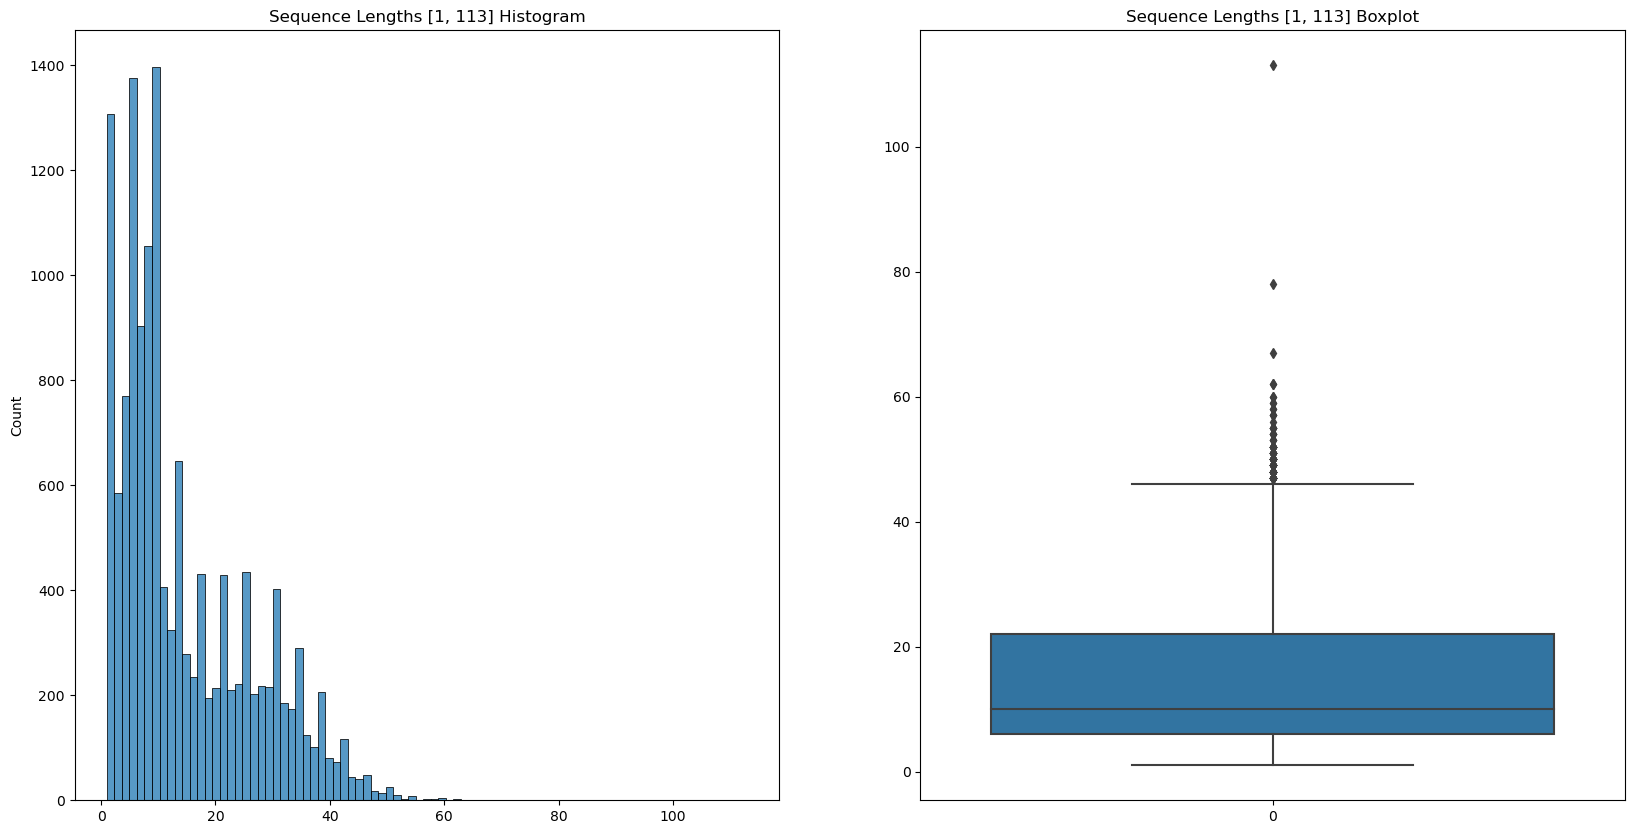

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(lengths, ax=ax[0])
sns.boxplot(lengths, ax=ax[1])
ax[0].set_title(f"Sequence Lengths [{min(lengths)}, {max(lengths)}] Histogram")
ax[1].set_title(f"Sequence Lengths [{min(lengths)}, {max(lengths)}] Boxplot")
plt.show()

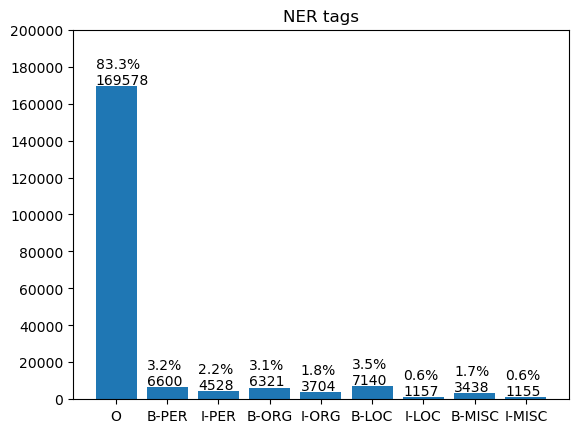

In [8]:
tag_counter = Counter(tags)

bars = plt.bar(tag_counter.keys(), tag_counter.values())

for bar in bars:
    bar_height = bar.get_height()
    percent = 100 * bar_height / len(tags)
    plt.annotate(f"{percent:.1f}%\n{bar_height}", xy=(bar.get_x(), bar_height + 1000))

plt.title(f"NER tags")
plt.xticks(list(tag_counter.keys()), [id2tag[i] for i in list(tag_counter.keys())])
plt.yticks(np.arange(0, 200001, 20000))
plt.show()

Create vocabulary

In [26]:
UNKNOWN = '<unk>'
tokens.append(UNKNOWN)

vocab = set(tokens)

# Create dictionaries to convert between tokens and indices
id2tok = {i: tok for i, tok in enumerate(set(tokens))}
tok2id = {tok: i for i, tok in enumerate(set(tokens))}

### 1.2 &ensp; Data preparation

Transform Hugging-Face dataset into PyTorch dataset

In [10]:
class SequenceTaggingDataset(Dataset):
    def __init__(self, sequence_tokens, sequence_tags):
        self.X = sequence_tokens
        self.y = sequence_tags

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [11]:
def tokens_to_ids(token_sequences):
    return [
        [tok2id.get(tok, tok2id[UNKNOWN]) for tok in tokens]
        for tokens in token_sequences
    ]

In [12]:
train_dataset = SequenceTaggingDataset(tokens_to_ids(conll2003_dataset['train'][:]['tokens']), conll2003_dataset['train'][:]['ner_tags'])
val_dataset = SequenceTaggingDataset(tokens_to_ids(conll2003_dataset['validation'][:]['tokens']), conll2003_dataset['validation'][:]['ner_tags'])
test_dataset = SequenceTaggingDataset(tokens_to_ids(conll2003_dataset['test'][:]['tokens']), conll2003_dataset['test'][:]['ner_tags'])

In [13]:
token_ids, tag_ids = train_dataset[0]

pd.DataFrame({
    'Token': [id2tok[tok_id] for tok_id in token_ids],
    'NER Tag': [id2tag[tag_id] for tag_id in tag_ids]
})

,Token,NER Tag
0,EU,B-ORG
1,rejects,O
2,German,B-MISC
3,call,O
4,to,O
5,boycott,O
6,British,B-MISC
7,lamb,O
8,.,O


Prepare for data loaders

In [14]:
def my_collate_fn(batch):
    packed_tokens = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    packed_labels = [torch.tensor(sample[1], dtype=torch.long) for sample in batch]
    return packed_tokens, packed_labels

Create data loaders (Training & Validation data loaders will be created as part of the training phase)

In [15]:
# Create a DataLoader object
test_dataloader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, collate_fn=my_collate_fn)

### 1.3 &ensp; Model 

Our RNN-based architecture is composed of the following blocks:
1. Pre-trained embeddings
2. LSTM layers
3. MLP classifier

In [22]:
class RnnSequenceTagger(nn.Module):
    def __init__(self, id2tok, embeddings, hidden_dim, num_tags, num_layers=3, dropout=0.1):
        super().__init__()
        
        self.__build_embeddings(embeddings, id2tok)
        self.lstm = nn.LSTM(input_size=len(embeddings[0]), 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            bidirectional=True, 
                            dropout=dropout, 
                            batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_tags)
        )

    def __build_embeddings(self, embeddings, id2token):
        
        embedding_size = len(embeddings[0])
        num_embeddings = len(id2token) + 1

        self.embedding = torch.randn(num_embeddings, embedding_size)

        # Select pretrained vectors
        for i, t in id2token.items():
            if t in embeddings:
                self.embedding[i] = torch.tensor(embeddings[t])

        self.embedding = nn.Embedding.from_pretrained(self.embedding, freeze=True)

    def forward(self, x):
        
        # Select embeddings
        unpacked_x = unpack_sequence(x)
        embeddings = [self.embedding(sample) for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)
        
        # Forward pass LSTM
        lstm_output, (_, _) = self.lstm(packed_embeddings)
 
        # Forward pass MLP
        output = [self.mlp(sequence_token_encodings) for sequence_token_encodings in unpack_sequence(lstm_output)]
            
        return output

### 1.4 &ensp; Experiments

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
def train(batch_size, hidden_dim, num_layers, dropout, lr, num_epochs, patience):
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    model = RnnSequenceTagger(id2tok, 
                              glove_embeddings, 
                              hidden_dim=hidden_dim, 
                              num_tags=len(id2tag), 
                              num_layers=num_layers, 
                              dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_losses = []
    val_losses = []
    patience_counter = 0
    best_loss = float('inf')    

    # Epochs
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        print(f'--------------------- Epoch {epoch}/{num_epochs} ---------------------')

        # Training
        model.train()
        with tqdm(total=len(train_dataloader), file=sys.stdout, position=0) as pbar:
            for inputs, targets in train_dataloader:
                inputs = inputs.to(device)
                targets = torch.cat(targets).to(device)

                # Forward pass
                model.zero_grad()
                outputs = model(inputs)
                loss = criterion(torch.cat(outputs), targets)

                # Backward pass
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                
                pbar.set_description(f'Training Loss ({loss.item():.3f})')
                pbar.update()
            
            pbar.set_description(f'Training Loss ({train_loss / len(train_dataloader):.3f})')

        # Validation
        model.eval()
        with torch.no_grad():
            with tqdm(total=len(val_dataloader), file=sys.stdout, position=0) as pbar:
                for inputs, targets in val_dataloader:
                    inputs = inputs.to(device)
                    targets = torch.cat(targets).to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(torch.cat(outputs), targets)

                    val_loss += loss.item()
                    
                    pbar.set_description(f'Validation Loss ({loss.item():.3f})')
                    pbar.update()
                
                pbar.set_description(f'Validation Loss ({val_loss / len(val_dataloader):.3f})')

        # Calculate average losses
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        # Save losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Check for early stopping
        if val_losses[-1] >= best_loss:
            patience_counter += 1
            if patience_counter >= patience:
                break
        else:
            patience_counter = 0
            best_model = copy.deepcopy(model)
            best_loss = val_losses[-1]
            best_epoch = epoch

    print(f'\n==> Best epoch: {best_epoch} :: Val Loss: {best_loss:.4f}, Perplexity: {np.exp(best_loss):.4f}')
    return best_model, train_losses, val_losses

The experiments search for hyperparameters such as:
- Batch size
- Hidden LSTM dimension
- Number of LSTM layers
- Dropout probability
- Learning Rate

In [19]:
random.seed(42)

batch_sizes = random.choices(config['rnn']['hyperparameters']['batch_size'], k=config['rnn']['num_experiments'])
hidden_dims = random.choices(config['rnn']['hyperparameters']['hidden_dim'], k=config['rnn']['num_experiments'])
layer_nums = random.choices(config['rnn']['hyperparameters']['num_layers'], k=config['rnn']['num_experiments'])
dropouts = random.choices(config['rnn']['hyperparameters']['dropout'], k=config['rnn']['num_experiments'])
lrs = random.choices(config['rnn']['hyperparameters']['learning_rate'], k=config['rnn']['num_experiments'])

models = []
train_results = []
val_results = []

for e, (batch_size, hidden_dim, num_layers, dropout, lr) in enumerate(zip(batch_sizes, hidden_dims, layer_nums, dropouts, lrs), start=1):
    print(f'\n{e}/{config["rnn"]["num_experiments"]} ====================== B{batch_size}_H{hidden_dim}_L{num_layers}_D{dropout}_LR{lr} ======================\n')
    
    model, train_losses, val_losses = train(batch_size, 
                                            hidden_dim, 
                                            num_layers, 
                                            dropout, 
                                            lr, 
                                            config['rnn']['max_num_epochs'], 
                                            config['rnn']['patience'])
    
    models.append(model)
    train_results.append(train_losses)
    val_results.append(val_losses)


1/20 ====================== B256_H600_L4_D0.3_LR0.0001 ======================



--------------------- Epoch 1/100 ---------------------
Validation Loss (0.762): 100%|██████████| 13/13 [00:00<00:00, 17.80it/s]
--------------------- Epoch 2/100 ---------------------
Validation Loss (0.689): 100%|██████████| 13/13 [00:00<00:00, 18.15it/s]
--------------------- Epoch 3/100 ---------------------
Validation Loss (0.546): 100%|██████████| 13/13 [00:00<00:00, 15.82it/s]
--------------------- Epoch 4/100 ---------------------
Validation Loss (0.455): 100%|██████████| 13/13 [00:00<00:00, 17.76it/s]
--------------------- Epoch 5/100 ---------------------
Validation Loss (0.396): 100%|██████████| 13/13 [00:00<00:00, 17.88it/s]
--------------------- Epoch 6/100 ---------------------
Validation Loss (0.406): 100%|██████████| 13/13 [00:00<00:00, 14.43it/s]
--------------------- Epoch 7/100 ---------------------
Validation Loss (0.395): 100%|██████████| 13/13 [00:00<00:00, 17.04it/s]
--------------------- Epoch 8/100 ---------------------
Validation Loss (0.374): 100%|██████████|

/tmp/ipykernel_56674/2380176491.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_setups = np.array(list(zip(batch_sizes, hidden_dims, layer_nums, dropouts, lrs, train_results, val_results)))


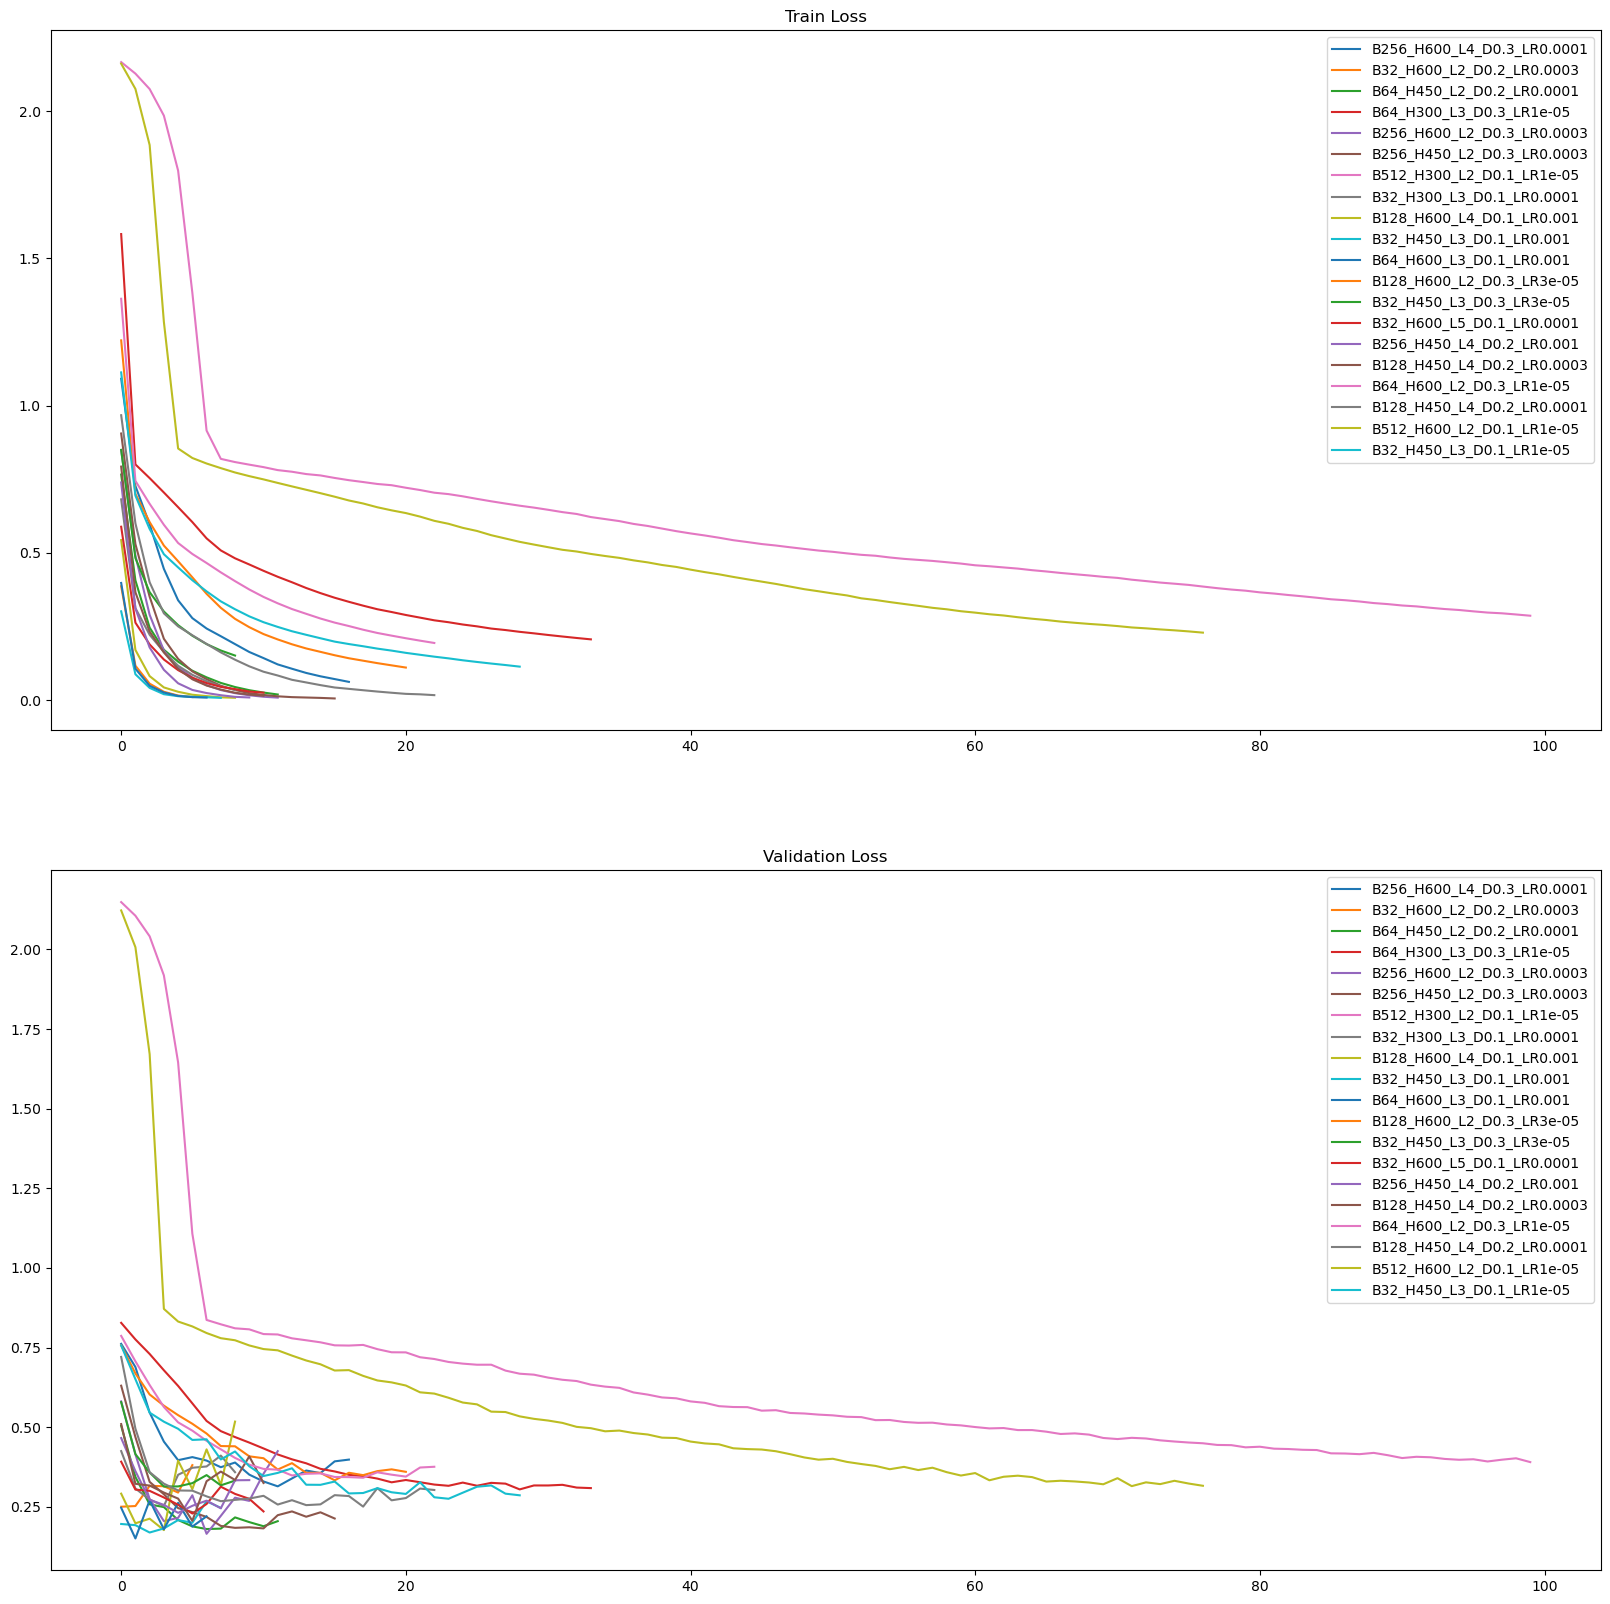

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
epoch_ticks = np.arange(1, config['rnn']['max_num_epochs'] + 1)

model_metrics = np.array([min(val_losses) for val_losses in val_results])
best_trails = np.array(model_metrics) <= np.percentile(model_metrics, 25)
best_setups = np.array(list(zip(batch_sizes, hidden_dims, layer_nums, dropouts, lrs, train_results, val_results)))

for B, H, L, D, LR, train_losses, val_losses in best_setups:

    ax[0].plot(train_losses, label=f"B{B}_H{H}_L{L}_D{D}_LR{LR}")
    ax[0].set_title("Train Loss")
    ax[0].legend(loc='best')
    ax[1].plot(val_losses, label=f"B{B}_H{H}_L{L}_D{D}_LR{LR}")
    ax[1].set_title("Validation Loss")
    ax[1].legend(loc='best')

### 1.5 &ensp; Evaluation

We calculate different metrics such as:

- Precision
- Recall 
- F1-score
- Acuracy

In [70]:
metric_seqeval = evaluate.load("seqeval")
metric_scores = []

for model in models:
    y_pred = []
    y_true = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            targets = torch.cat(targets).to(device)
            outputs = torch.cat(model(inputs.to(device)))        
            
            y_pred.extend(np.argmax(outputs.to('cpu'), axis=1).numpy())
            y_true.extend(targets.to('cpu').numpy())
            
    predictions = [id2tag[i] for i in y_pred]
    labels = [id2tag[i] for i in y_true]
    
    metric_scores.append(metric_seqeval.compute(predictions=[predictions], references=[labels]))

In [72]:
results = pd.DataFrame({
    "Batch size": batch_sizes,
    "Hidden dim": hidden_dims,
    "Num layers": layer_nums,
    "Dropot": dropouts,
    "Learning rate": lrs,
    "F1 score": [score['overall_f1'] for score in metric_scores]
}).sort_values(by='F1 score', ascending=False)

results

,Batch size,Hidden dim,Num layers,Dropot,Learning rate,F1 score
10,64,600,3,0.1,0.00100,0.696766
4,256,600,2,0.3,0.00030,0.676837
9,32,450,3,0.1,0.00100,0.668332
5,256,450,2,0.3,0.00030,0.656879
2,64,450,2,0.2,0.00010,0.648270
8,128,600,4,0.1,0.00100,0.640794
17,128,450,4,0.2,0.00010,0.597098
15,128,450,4,0.2,0.00030,0.596485
14,256,450,4,0.2,0.00100,0.557530
19,32,450,3,0.1,0.00001,0.552175


In [78]:
best_rnn_model = models[results.index[0]]
best_rnn_model

RnnSequenceTagger(
  (embedding): Embedding(23625, 300)
  (lstm): LSTM(300, 600, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (mlp): Sequential(
    (0): Linear(in_features=1200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=9, bias=True)
  )
)

In [79]:
metric_scores[results.index[0]]

{'LOC': {'precision': 0.8868205510052122,
  'recall': 0.7140287769784173,
  'f1': 0.79109930255729,
  'number': 1668},
 'MISC': {'precision': 0.7300509337860781,
  'recall': 0.6125356125356125,
  'f1': 0.6661502711076684,
  'number': 702},
 'ORG': {'precision': 0.7074877536738978,
  'recall': 0.6086694762191451,
  'f1': 0.6543689320388351,
  'number': 1661},
 'PER': {'precision': 0.5835654596100278,
  'recall': 0.7773654916512059,
  'f1': 0.6666666666666666,
  'number': 1617},
 'overall_precision': 0.7051677243880327,
 'overall_recall': 0.6885623229461756,
 'overall_f1': 0.6967661023022486,
 'overall_accuracy': 0.9349197803381071}

## 2 &ensp; Pre-Trained Transformer

* For the pre-trained transformer approach, the BERT-base model is used.
* Encoder-based models are usually preferred for token classification tasks like NER, \
in which the model is allowed to extract information from the whole sequence, \
rather than referring only to tokens that come before a certain token (e.g. Language Modelling).


### 2.1 &ensp; Data preparation

In [4]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

sequence = conll2003_dataset["train"][2]["tokens"]
tokenized_input = tokenizer(sequence, is_split_into_words=True)

sequence, tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

(['BRUSSELS', '1996-08-22'],
 ['[CLS]', 'brussels', '1996', '-', '08', '-', '22', '[SEP]'])

When using the tokenizer we need to align the labels to the new tokens. \
Each original token is transformed into a group of new tokens. \
The first token of each group is assigned the original label, and the rest are assigned with a special IGNORE label.

In [5]:
IGNORE_ID = -100

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        # Align labels to new token
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(IGNORE_ID)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(IGNORE_ID)
            previous_word_idx = word_idx
            
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
tokenized_conll2003 = conll2003_dataset.map(tokenize_and_align_labels, batched=True)

In [83]:
id2tag[IGNORE_ID]='ignore'
example = tokenized_conll2003['train'][2]

pd.DataFrame({
    'tokens': tokenizer.convert_ids_to_tokens(example["input_ids"]), 
    'ner_labels': example['labels'], 
    'ner_tags': [id2tag[label] for label in example['labels']] 
})

,tokens,ner_labels,ner_tags
0,[CLS],-100,ignore
1,brussels,5,B-LOC
2,1996,0,O
3,-,-100,ignore
4,08,-100,ignore
5,-,-100,ignore
6,22,-100,ignore
7,[SEP],-100,ignore


### 2.2 &ensp; Fine-Tuning

Create helper functions for fine-tuning phase & evaluation

In [7]:
def compute_metrics(predictions, labels, eval=False):
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != IGNORE_ID]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != IGNORE_ID]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric_seqeval.compute(predictions=true_predictions, references=true_labels)
    
    return results if eval else {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
    
def compute_metrics_wrapper(results):
    return compute_metrics(*results)

def model_init(trial):
    return AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(tag_names))

In [8]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

We do not use all the training data, but a small portion of the data

In [12]:
trainers = dict()

for train_size in config['transformer']['hyperparameters']['training_samples']:

    training_args = TrainingArguments(
        output_dir='/home/omrigu/code/log_results',
        num_train_epochs=config['transformer']['max_num_epochs'],
        eval_steps=1 / (config['transformer']['max_num_epochs'] * config['transformer']['evals_per_epoch']),
        save_steps=1 / (config['transformer']['max_num_epochs'] * config['transformer']['evals_per_epoch']),
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        disable_tqdm=False
    )

    trainer = Trainer(
        args=training_args,
        train_dataset=tokenized_conll2003["train"].select(range(train_size)),
        eval_dataset=tokenized_conll2003["validation"],
        compute_metrics=compute_metrics_wrapper,
        tokenizer=tokenizer,
        model_init=model_init,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=config['transformer']['patience'])]
    )

    trainer.train()
    
    trainers[train_size] = trainer

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
13,No log,0.728095,0.055556,0.000168,0.000336,0.832795
26,No log,0.404129,0.463532,0.469539,0.466516,0.910887
39,No log,0.320107,0.548617,0.570683,0.559432,0.921732
52,No log,0.290297,0.628160,0.660720,0.644029,0.938145
65,No log,0.249256,0.650248,0.706496,0.677206,0.944297
78,No log,0.248579,0.673086,0.723494,0.697380,0.948892
91,No log,0.254492,0.623560,0.719791,0.668229,0.947607
104,No log,0.239092,0.695253,0.739482,0.716686,0.953156
117,No log,0.215519,0.728350,0.765735,0.746575,0.956836
130,No log,0.213380,0.725337,0.779536,0.751460,0.958802


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementatio

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
26,No log,0.353667,0.448747,0.524571,0.483706,0.915755
52,No log,0.220978,0.635744,0.705823,0.668953,0.942487
78,No log,0.187078,0.695606,0.767250,0.729673,0.955765
104,No log,0.149666,0.772372,0.830865,0.800551,0.963163
130,No log,0.125428,0.820645,0.856277,0.838083,0.970951
156,No log,0.139800,0.830895,0.840963,0.835898,0.969978
182,No log,0.125818,0.821394,0.852911,0.836856,0.970893
208,No log,0.128766,0.806877,0.864860,0.834863,0.968693


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementatio

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
52,No log,0.250262,0.658899,0.670986,0.664888,0.940520
104,No log,0.138974,0.807466,0.855436,0.830759,0.968634
156,No log,0.132926,0.817575,0.845507,0.831306,0.970114
208,No log,0.130674,0.844023,0.861494,0.852669,0.972470
260,No log,0.113364,0.843885,0.890609,0.866618,0.974086
312,No log,0.106767,0.871352,0.899360,0.885135,0.977123
364,No log,0.095519,0.893327,0.903400,0.898335,0.980083
416,No log,0.093536,0.880262,0.904409,0.892172,0.980005
468,No log,0.102136,0.860599,0.903904,0.881720,0.976169
520,0.123100,0.096510,0.875425,0.910636,0.892683,0.980199


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
103,No log,0.127128,0.807186,0.835577,0.821136,0.968459
206,No log,0.088990,0.865730,0.891956,0.878647,0.976461
309,No log,0.081111,0.886792,0.893807,0.890286,0.979284
412,No log,0.081777,0.878005,0.903568,0.890603,0.979187
515,0.152500,0.091367,0.872701,0.902221,0.887216,0.978544
618,0.152500,0.072904,0.903429,0.917873,0.910594,0.982789
721,0.152500,0.065171,0.903878,0.917873,0.910822,0.983042
824,0.152500,0.074349,0.894070,0.926119,0.909812,0.982030
927,0.152500,0.071005,0.907614,0.930831,0.919076,0.984230
1030,0.034900,0.068553,0.919960,0.928475,0.924198,0.985145


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
205,No log,0.095776,0.880663,0.876809,0.878732,0.975858
410,No log,0.073050,0.905462,0.912319,0.908878,0.981679
615,0.159500,0.081909,0.885658,0.912487,0.898873,0.979868
820,0.159500,0.060396,0.905170,0.925278,0.915113,0.983276
1025,0.068300,0.064111,0.919363,0.932514,0.925892,0.985184
1230,0.068300,0.059226,0.925680,0.939078,0.932331,0.986624
1435,0.068300,0.064352,0.920548,0.937900,0.929143,0.985846
1640,0.025000,0.063718,0.916108,0.942780,0.929253,0.985573
1845,0.025000,0.056071,0.926123,0.936722,0.931392,0.986722
2050,0.027800,0.057474,0.930170,0.937058,0.933602,0.987053


In [ ]:
train_size_results = {
    'Train samples': [],
    'Location F1': [],
    'Misc F1': [],
    'Organization F1': [],
    'Person F1': [],
    'Overall F1': []
}

for train_size, trainer in trainers.items():
    predictions, labels, _ = trainer.predict(tokenized_conll2003['validation'])
    metrics = compute_metrics(predictions, labels, eval=True)
    
    train_size_results['Train samples'].append(train_size)
    train_size_results['Location F1'].append(metrics['LOC']['f1'])
    train_size_results['Misc F1'].append(metrics['MISC']['f1'])
    train_size_results['Organization F1'].append(metrics['ORG']['f1'])
    train_size_results['Person F1'].append(metrics['PER']['f1'])
    train_size_results['Overall F1'].append(metrics['overall_f1'])

In [14]:
pd.DataFrame(train_size_results, index=np.arange(len(trainers)))

,Train samples,Location F1,Misc F1,Organization F1,Person F1,Overall F1
0,512,0.746793,0.620011,0.581532,0.936432,0.751460
1,1024,0.894526,0.638905,0.756830,0.941017,0.838083
2,2048,0.917451,0.776658,0.836018,0.966855,0.892172
3,4096,0.936771,0.824158,0.855892,0.969829,0.910822
4,8192,0.951167,0.867965,0.889382,0.973890,0.931392


In [9]:
optimal_train_size = 2048

We search for optimal hyperparameters such as:
- Learning rate
- Batch size

In [13]:
batch_sizes = config['transformer']['hyperparameters']['batch_size']
lrs = config['transformer']['hyperparameters']['learning_rate']
metric_scores = []

for batch_size, lr in product(batch_sizes, lrs):
    
    training_args = TrainingArguments(
        output_dir='/home/omrigu/code/log_results',
        per_device_train_batch_size=batch_size,
        learning_rate=lr,
        num_train_epochs=config['transformer']['max_num_epochs'],
        eval_steps=1 / (config['transformer']['max_num_epochs'] * config['transformer']['evals_per_epoch']),
        save_steps=1 / (config['transformer']['max_num_epochs'] * config['transformer']['evals_per_epoch']),
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        disable_tqdm=False
    )
    
    trainer = Trainer(
        args=training_args,
        train_dataset=tokenized_conll2003["train"].select(range(optimal_train_size)),
        eval_dataset=tokenized_conll2003["validation"],
        compute_metrics=compute_metrics_wrapper,
        tokenizer=tokenizer,
        model_init=model_init,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=config['transformer']['patience'])]
    )
    
    trainer.train()
    
    predictions, labels, _ = trainer.predict(tokenized_conll2003["test"])    
    metric_scores.append(compute_metrics(predictions, labels, eval=True))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
7,No log,0.901566,0.000000,0.000000,0.000000,0.832503
14,No log,0.722139,0.000000,0.000000,0.000000,0.832503
21,No log,0.542318,0.583877,0.165769,0.258225,0.858319
28,No log,0.397952,0.354868,0.397509,0.374980,0.903917
35,No log,0.326153,0.495551,0.553012,0.522707,0.922978
42,No log,0.275578,0.568459,0.658196,0.610045,0.935147
49,No log,0.239396,0.632593,0.718613,0.672865,0.945758
56,No log,0.217767,0.636390,0.728711,0.679429,0.949807
63,No log,0.208272,0.621551,0.724167,0.668947,0.949749
70,No log,0.189304,0.673166,0.761192,0.714478,0.956816


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarn

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
7,No log,0.611134,0.908257,0.016661,0.032722,0.834489
14,No log,0.326645,0.348467,0.441770,0.389610,0.909641
21,No log,0.238500,0.660924,0.710199,0.684676,0.947705
28,No log,0.164160,0.740815,0.804275,0.771242,0.962677
35,No log,0.146053,0.772255,0.826321,0.798374,0.965539
42,No log,0.125085,0.833333,0.868394,0.850503,0.972450
49,No log,0.109688,0.852630,0.881185,0.866672,0.974631
56,No log,0.108283,0.842834,0.880848,0.861422,0.974845
63,No log,0.111030,0.841260,0.881185,0.860759,0.975137
70,No log,0.097359,0.873478,0.893470,0.883361,0.977785


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
4,No log,1.173773,0.000000,0.000000,0.000000,0.832464
8,No log,0.878288,0.000000,0.000000,0.000000,0.832503
12,No log,0.707549,0.000000,0.000000,0.000000,0.832503
16,No log,0.620321,0.858639,0.027600,0.053481,0.835871
20,No log,0.520366,0.566412,0.187311,0.281523,0.860714
24,No log,0.451996,0.387292,0.301582,0.339105,0.889159
28,No log,0.405036,0.368764,0.400539,0.383995,0.904209
32,No log,0.374388,0.365666,0.432683,0.396362,0.907694
36,No log,0.351537,0.397851,0.467351,0.429810,0.912542
40,No log,0.335336,0.445448,0.506395,0.473970,0.917896


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarn

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
4,No log,0.885984,0.000000,0.000000,0.000000,0.832503
8,No log,0.534145,0.535423,0.209862,0.301535,0.869008
12,No log,0.351735,0.387383,0.447492,0.415274,0.909700
16,No log,0.261197,0.607512,0.672333,0.638281,0.936665
20,No log,0.212895,0.666211,0.738304,0.700407,0.949184
24,No log,0.177827,0.701062,0.788960,0.742418,0.959562
28,No log,0.150823,0.731087,0.803433,0.765555,0.963923
32,No log,0.145340,0.738656,0.808145,0.771840,0.964585
36,No log,0.127306,0.789317,0.845507,0.816446,0.969394
40,No log,0.118908,0.826703,0.863851,0.844869,0.972684


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
2,No log,1.604496,0.052922,0.024234,0.033245,0.792960
4,No log,1.183033,0.000000,0.000000,0.000000,0.832464
6,No log,0.922264,0.000000,0.000000,0.000000,0.832503
8,No log,0.870414,0.000000,0.000000,0.000000,0.832503
10,No log,0.811260,0.000000,0.000000,0.000000,0.832503
12,No log,0.728527,0.000000,0.000000,0.000000,0.832503
14,No log,0.676851,0.000000,0.000000,0.000000,0.832522
16,No log,0.649112,0.857143,0.003029,0.006037,0.832873
18,No log,0.624066,0.842857,0.019859,0.038803,0.834975
20,No log,0.600698,0.838527,0.049815,0.094043,0.838636


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarn

/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/omrigu/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementatio

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
2,No log,0.921627,0.000000,0.000000,0.000000,0.832503
4,No log,0.773013,0.000000,0.000000,0.000000,0.832503
6,No log,0.619994,0.600000,0.000505,0.001009,0.832581
8,No log,0.502788,0.565039,0.208347,0.304439,0.864803
10,No log,0.429202,0.383118,0.344497,0.362782,0.898154
12,No log,0.370222,0.364407,0.412487,0.386959,0.906039
14,No log,0.325833,0.416774,0.491754,0.451170,0.915443
16,No log,0.293820,0.505587,0.586335,0.542975,0.926814
18,No log,0.269325,0.574866,0.647425,0.608992,0.934485
20,No log,0.254595,0.622280,0.683440,0.651428,0.939683


/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omrigu/.local/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Pre

### 2.3 &ensp; Evaluation

In [19]:
BS, LR = list(zip(*list(product(batch_sizes, lrs))))

results = pd.DataFrame({
    "Batch size": BS,
    "Learning rate": LR,
    "F1 score": [score['overall_f1'] for score in metric_scores]
}).sort_values(by='F1 score', ascending=False)

results

,Batch size,Learning rate,F1 score
1,64,0.00010,0.858345
3,128,0.00010,0.831498
0,64,0.00003,0.698734
5,256,0.00010,0.616717
2,128,0.00003,0.486245
4,256,0.00003,0.155828


In [20]:
model_metrics[results.index[0]]

{'LOC': {'precision': 0.8755186721991701,
  'recall': 0.8854916067146283,
  'f1': 0.8804769001490313,
  'number': 1668},
 'MISC': {'precision': 0.6987620357634112,
  'recall': 0.7236467236467237,
  'f1': 0.7109867039888033,
  'number': 702},
 'ORG': {'precision': 0.7887485648679678,
  'recall': 0.827212522576761,
  'f1': 0.807522774022921,
  'number': 1661},
 'PER': {'precision': 0.9582294264339152,
  'recall': 0.9505256648113791,
  'f1': 0.9543619993790748,
  'number': 1617},
 'overall_precision': 0.85,
 'overall_recall': 0.8668555240793201,
 'overall_f1': 0.858345021037868,
 'overall_accuracy': 0.9724561214601055}

## 3 &ensp; Comparison

After doing some experiments exploring both approches, we can compare them according to several aspects.

The optimal setups from both approches were the following:

Setup | Pre-Trained Transformer | RNN-based
:--- | :--- | :---
Architecture | BERT | GloVe + LSTM + MLP
Hyperparameters | Batch size `8` <br> Learning rate `3e-5` | Batch size `64` <br> Hidden dim `600` <br> Num layers `3` <br> Dropout `0.1` <br> Learning rate `1e-3`
Parameters | `~110M` | `~29.4M`
Training examples | `~2K` | `~14K`
Epochs | `~2.2` | `2`

The results from all the experiments show some interesting differences between the RNN approach to the BERT approach:

- **Shorter training** - We can generally see that most of the RNN-based models required somewhere between `10 to 30 epochs` to train, \
while the BERT-based models required no more than `3 epochs`.
- **Higher scores** - Adding to that, the RNN-based models did not manage to achieve f1-score higher than `0.7`, \
while the BERT-based models quite easily passed the `0.9` mark.
- **Less training data** - At last, the RNN-based models were trained on all the training data, comprised of `~14K` samples, \
while the BERT-based models could be trained on `~2K` samples, with no significant change to performance.

From the metric scores from both setups we can conclude:

- RNN-based approach achieved relatively high score (`0.79`) for the Location entities, \
while on the other entities it only scored around `0.65 to 0.69`, as well as the overall score.
- BERT-based approach achieved amazing results on Person entities (`0.96`) and on Location entities (`0.91`), \
while it slightly drop to `0.83` on Organization entities, and did worst on Misc entities (`0.77`), \
with an overall score of `0.89`.

## 4 &ensp; Conclusions

To sum up, the results show that the BERT approach was undoubtedly better. \
It takes less time to fine-tune a BERT-based model while using less data, and the results are far better. 
